In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_025_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:33 - loss: 0.0657 - STD: 2.4443e-04 - MAE: 0.2396

 4/74 [>.............................] - ETA: 2s - loss: 0.0275 - STD: 3.2716e-04 - MAE: 0.1293  

 5/74 [=>............................] - ETA: 2s - loss: 0.0268 - STD: 2.9471e-04 - MAE: 0.1281

 6/74 [=>............................] - ETA: 2s - loss: 0.0265 - STD: 2.6672e-04 - MAE: 0.1279

 7/74 [=>............................] - ETA: 3s - loss: 0.0264 - STD: 2.4307e-04 - MAE: 0.1282

 8/74 [==>...........................] - ETA: 3s - loss: 0.0261 - STD: 2.2350e-04 - MAE: 0.1280

 9/74 [==>...........................] - ETA: 3s - loss: 0.0258 - STD: 2.0716e-04 - MAE: 0.1273

10/74 [===>..........................] - ETA: 3s - loss: 0.0254 - STD: 1.9349e-04 - MAE: 0.1260

11/74 [===>..........................] - ETA: 3s - loss: 0.0248 - STD: 1.8215e-04 - MAE: 0.1242

12/74 [===>..........................] - ETA: 3s - loss: 0.0241 - STD: 1.7263e-04 - MAE: 0.1215

13/74 [====>.........................] - ETA: 3s - loss: 0.0232 - STD: 1.6486e-04 - MAE: 0.1185

14/74 [====>.........................] - ETA: 3s - loss: 0.0223 - STD: 1.5855e-04 - MAE: 0.1154

15/74 [=====>........................] - ETA: 3s - loss: 0.0215 - STD: 1.5330e-04 - MAE: 0.1127

16/74 [=====>........................] - ETA: 3s - loss: 0.0207 - STD: 1.4890e-04 - MAE: 0.1105

17/74 [=====>........................] - ETA: 3s - loss: 0.0201 - STD: 1.4512e-04 - MAE: 0.1089

18/74 [======>.......................] - ETA: 3s - loss: 0.0196 - STD: 1.4190e-04 - MAE: 0.1081

19/74 [======>.......................] - ETA: 3s - loss: 0.0193 - STD: 1.3911e-04 - MAE: 0.1076

20/74 [=======>......................] - ETA: 3s - loss: 0.0190 - STD: 1.3673e-04 - MAE: 0.1072

21/74 [=======>......................] - ETA: 3s - loss: 0.0187 - STD: 1.3465e-04 - MAE: 0.1066

22/74 [=======>......................] - ETA: 3s - loss: 0.0184 - STD: 1.3287e-04 - MAE: 0.1058

23/74 [========>.....................] - ETA: 3s - loss: 0.0180 - STD: 1.3135e-04 - MAE: 0.1048

24/74 [========>.....................] - ETA: 2s - loss: 0.0176 - STD: 1.3002e-04 - MAE: 0.1037

25/74 [=========>....................] - ETA: 2s - loss: 0.0173 - STD: 1.2883e-04 - MAE: 0.1026

26/74 [=========>....................] - ETA: 2s - loss: 0.0170 - STD: 1.2771e-04 - MAE: 0.1014

27/74 [=========>....................] - ETA: 2s - loss: 0.0167 - STD: 1.2670e-04 - MAE: 0.1004

28/74 [==========>...................] - ETA: 2s - loss: 0.0165 - STD: 1.2577e-04 - MAE: 0.0995

29/74 [==========>...................] - ETA: 2s - loss: 0.0163 - STD: 1.2499e-04 - MAE: 0.0987

30/74 [===========>..................] - ETA: 2s - loss: 0.0161 - STD: 1.2433e-04 - MAE: 0.0979

31/74 [===========>..................] - ETA: 2s - loss: 0.0159 - STD: 1.2378e-04 - MAE: 0.0972

32/74 [===========>..................] - ETA: 2s - loss: 0.0157 - STD: 1.2337e-04 - MAE: 0.0965

33/74 [============>.................] - ETA: 2s - loss: 0.0156 - STD: 1.2316e-04 - MAE: 0.0958

34/74 [============>.................] - ETA: 2s - loss: 0.0154 - STD: 1.2311e-04 - MAE: 0.0952

35/74 [=============>................] - ETA: 2s - loss: 0.0152 - STD: 1.2325e-04 - MAE: 0.0946

36/74 [=============>................] - ETA: 2s - loss: 0.0151 - STD: 1.2353e-04 - MAE: 0.0940

37/74 [==============>...............] - ETA: 2s - loss: 0.0149 - STD: 1.2397e-04 - MAE: 0.0936

38/74 [==============>...............] - ETA: 2s - loss: 0.0148 - STD: 1.2450e-04 - MAE: 0.0931

39/74 [==============>...............] - ETA: 2s - loss: 0.0146 - STD: 1.2511e-04 - MAE: 0.0928

40/74 [===============>..............] - ETA: 2s - loss: 0.0145 - STD: 1.2585e-04 - MAE: 0.0924

41/74 [===============>..............] - ETA: 2s - loss: 0.0144 - STD: 1.2665e-04 - MAE: 0.0921

42/74 [================>.............] - ETA: 1s - loss: 0.0142 - STD: 1.2752e-04 - MAE: 0.0918

43/74 [================>.............] - ETA: 1s - loss: 0.0141 - STD: 1.2844e-04 - MAE: 0.0915

44/74 [================>.............] - ETA: 1s - loss: 0.0140 - STD: 1.2936e-04 - MAE: 0.0912

45/74 [=================>............] - ETA: 1s - loss: 0.0139 - STD: 1.3031e-04 - MAE: 0.0908

46/74 [=================>............] - ETA: 1s - loss: 0.0138 - STD: 1.3125e-04 - MAE: 0.0905

47/74 [==================>...........] - ETA: 1s - loss: 0.0137 - STD: 1.3226e-04 - MAE: 0.0902

48/74 [==================>...........] - ETA: 1s - loss: 0.0136 - STD: 1.3323e-04 - MAE: 0.0899

49/74 [==================>...........] - ETA: 1s - loss: 0.0135 - STD: 1.3418e-04 - MAE: 0.0895

50/74 [===================>..........] - ETA: 1s - loss: 0.0135 - STD: 1.3520e-04 - MAE: 0.0892

51/74 [===================>..........] - ETA: 1s - loss: 0.0134 - STD: 1.3625e-04 - MAE: 0.0889

52/74 [====================>.........] - ETA: 1s - loss: 0.0133 - STD: 1.3738e-04 - MAE: 0.0886

53/74 [====================>.........] - ETA: 1s - loss: 0.0132 - STD: 1.3858e-04 - MAE: 0.0884

54/74 [====================>.........] - ETA: 1s - loss: 0.0131 - STD: 1.3985e-04 - MAE: 0.0881

55/74 [=====================>........] - ETA: 1s - loss: 0.0131 - STD: 1.4123e-04 - MAE: 0.0879

56/74 [=====================>........] - ETA: 1s - loss: 0.0130 - STD: 1.4270e-04 - MAE: 0.0876

57/74 [======================>.......] - ETA: 1s - loss: 0.0129 - STD: 1.4422e-04 - MAE: 0.0874

58/74 [======================>.......] - ETA: 0s - loss: 0.0129 - STD: 1.4587e-04 - MAE: 0.0872

59/74 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 1.4757e-04 - MAE: 0.0870

60/74 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.4932e-04 - MAE: 0.0868

61/74 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 1.5114e-04 - MAE: 0.0867

62/74 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 1.5300e-04 - MAE: 0.0865

63/74 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 1.5490e-04 - MAE: 0.0864

64/74 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 1.5684e-04 - MAE: 0.0862

65/74 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 1.5883e-04 - MAE: 0.0860

66/74 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 1.6084e-04 - MAE: 0.0859

67/74 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 1.6285e-04 - MAE: 0.0857

68/74 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 1.6502e-04 - MAE: 0.0855

69/74 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 1.6717e-04 - MAE: 0.0854

70/74 [===========================>..] - ETA: 0s - loss: 0.0122 - STD: 1.6939e-04 - MAE: 0.0852

71/74 [===========================>..] - ETA: 0s - loss: 0.0122 - STD: 1.7175e-04 - MAE: 0.0851

72/74 [============================>.] - ETA: 0s - loss: 0.0122 - STD: 1.7411e-04 - MAE: 0.0849

74/74 [==============================] - 7s 77ms/step - loss: 0.0121 - STD: 1.7906e-04 - MAE: 0.0846 - val_loss: 0.0086 - val_STD: 2.5015e-04 - val_MAE: 0.0713


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0092 - STD: 3.7602e-04 - MAE: 0.0751

 2/74 [..............................] - ETA: 5s - loss: 0.0091 - STD: 3.8199e-04 - MAE: 0.0750

 3/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 3.8838e-04 - MAE: 0.0749

 4/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 3.9397e-04 - MAE: 0.0750

 5/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 4.0014e-04 - MAE: 0.0751

 6/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 4.0653e-04 - MAE: 0.0752

 7/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 4.1372e-04 - MAE: 0.0753

 8/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 4.2046e-04 - MAE: 0.0754

 9/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 4.2695e-04 - MAE: 0.0754

10/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.3369e-04 - MAE: 0.0753

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.4101e-04 - MAE: 0.0753

12/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.4801e-04 - MAE: 0.0753

13/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 4.5520e-04 - MAE: 0.0753

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 4.6258e-04 - MAE: 0.0753

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 4.7012e-04 - MAE: 0.0753

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 4.7844e-04 - MAE: 0.0753

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 4.8670e-04 - MAE: 0.0754

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 4.9515e-04 - MAE: 0.0753

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.0427e-04 - MAE: 0.0753

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.1314e-04 - MAE: 0.0753

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.2247e-04 - MAE: 0.0754

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.3220e-04 - MAE: 0.0754

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 5.4199e-04 - MAE: 0.0753

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 5.5223e-04 - MAE: 0.0753

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.6267e-04 - MAE: 0.0753

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.7324e-04 - MAE: 0.0753

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.8469e-04 - MAE: 0.0754

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 5.9651e-04 - MAE: 0.0754

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 6.0879e-04 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.2146e-04 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.3452e-04 - MAE: 0.0753

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.4786e-04 - MAE: 0.0753

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.6183e-04 - MAE: 0.0752

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.7633e-04 - MAE: 0.0752

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.9153e-04 - MAE: 0.0752

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 7.0722e-04 - MAE: 0.0753

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.2330e-04 - MAE: 0.0753

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.4020e-04 - MAE: 0.0752

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.5750e-04 - MAE: 0.0752

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 7.7578e-04 - MAE: 0.0752

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 7.9519e-04 - MAE: 0.0752

42/74 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 8.1491e-04 - MAE: 0.0752

43/74 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 8.3565e-04 - MAE: 0.0751

44/74 [================>.............] - ETA: 1s - loss: 0.0091 - STD: 8.5702e-04 - MAE: 0.0751

45/74 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 8.7968e-04 - MAE: 0.0752

46/74 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 9.0336e-04 - MAE: 0.0752

47/74 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 9.2769e-04 - MAE: 0.0751

48/74 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 9.5293e-04 - MAE: 0.0751

49/74 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 9.7962e-04 - MAE: 0.0751

50/74 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

51/74 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751

52/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

53/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

54/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

55/74 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

56/74 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

57/74 [======================>.......] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

58/74 [======================>.......] - ETA: 1s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0751

59/74 [======================>.......] - ETA: 1s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0751

60/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

61/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

62/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

63/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

64/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0750

65/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0749

66/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0749

67/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0749

68/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0748

69/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0748

70/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0748

72/74 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0747

73/74 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0747

74/74 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0747

74/74 [==============================] - 5s 70ms/step - loss: 0.0090 - STD: 0.0024 - MAE: 0.0747 - val_loss: 0.0078 - val_STD: 0.0068 - val_MAE: 0.0684


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0086 - STD: 0.0104 - MAE: 0.0728

 2/74 [..............................] - ETA: 5s - loss: 0.0085 - STD: 0.0108 - MAE: 0.0724

 3/74 [>.............................] - ETA: 4s - loss: 0.0084 - STD: 0.0112 - MAE: 0.0721

 4/74 [>.............................] - ETA: 4s - loss: 0.0083 - STD: 0.0116 - MAE: 0.0720

 5/74 [=>............................] - ETA: 4s - loss: 0.0083 - STD: 0.0119 - MAE: 0.0718

 6/74 [=>............................] - ETA: 4s - loss: 0.0083 - STD: 0.0124 - MAE: 0.0718

 7/74 [=>............................] - ETA: 4s - loss: 0.0083 - STD: 0.0128 - MAE: 0.0717

 8/74 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.0132 - MAE: 0.0715

 9/74 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.0137 - MAE: 0.0714

10/74 [===>..........................] - ETA: 4s - loss: 0.0081 - STD: 0.0142 - MAE: 0.0713

11/74 [===>..........................] - ETA: 4s - loss: 0.0081 - STD: 0.0147 - MAE: 0.0712

12/74 [===>..........................] - ETA: 4s - loss: 0.0081 - STD: 0.0152 - MAE: 0.0711

13/74 [====>.........................] - ETA: 4s - loss: 0.0080 - STD: 0.0157 - MAE: 0.0709

14/74 [====>.........................] - ETA: 4s - loss: 0.0080 - STD: 0.0162 - MAE: 0.0707

15/74 [=====>........................] - ETA: 3s - loss: 0.0080 - STD: 0.0168 - MAE: 0.0706

16/74 [=====>........................] - ETA: 3s - loss: 0.0080 - STD: 0.0173 - MAE: 0.0704

17/74 [=====>........................] - ETA: 3s - loss: 0.0079 - STD: 0.0179 - MAE: 0.0703

18/74 [======>.......................] - ETA: 3s - loss: 0.0079 - STD: 0.0184 - MAE: 0.0702

19/74 [======>.......................] - ETA: 3s - loss: 0.0079 - STD: 0.0190 - MAE: 0.0701

20/74 [=======>......................] - ETA: 3s - loss: 0.0079 - STD: 0.0196 - MAE: 0.0700

21/74 [=======>......................] - ETA: 3s - loss: 0.0078 - STD: 0.0202 - MAE: 0.0699

22/74 [=======>......................] - ETA: 3s - loss: 0.0078 - STD: 0.0207 - MAE: 0.0698

23/74 [========>.....................] - ETA: 3s - loss: 0.0078 - STD: 0.0213 - MAE: 0.0697

24/74 [========>.....................] - ETA: 3s - loss: 0.0078 - STD: 0.0219 - MAE: 0.0695

25/74 [=========>....................] - ETA: 3s - loss: 0.0077 - STD: 0.0225 - MAE: 0.0694

26/74 [=========>....................] - ETA: 3s - loss: 0.0077 - STD: 0.0230 - MAE: 0.0693

27/74 [=========>....................] - ETA: 3s - loss: 0.0077 - STD: 0.0236 - MAE: 0.0692

28/74 [==========>...................] - ETA: 3s - loss: 0.0077 - STD: 0.0241 - MAE: 0.0691

29/74 [==========>...................] - ETA: 2s - loss: 0.0076 - STD: 0.0247 - MAE: 0.0690

30/74 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.0252 - MAE: 0.0688

31/74 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.0257 - MAE: 0.0687

32/74 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.0261 - MAE: 0.0686

33/74 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.0266 - MAE: 0.0685

34/74 [============>.................] - ETA: 2s - loss: 0.0075 - STD: 0.0270 - MAE: 0.0684

35/74 [=============>................] - ETA: 2s - loss: 0.0075 - STD: 0.0275 - MAE: 0.0683

36/74 [=============>................] - ETA: 2s - loss: 0.0075 - STD: 0.0279 - MAE: 0.0682

37/74 [==============>...............] - ETA: 2s - loss: 0.0075 - STD: 0.0283 - MAE: 0.0681

38/74 [==============>...............] - ETA: 2s - loss: 0.0075 - STD: 0.0287 - MAE: 0.0680

39/74 [==============>...............] - ETA: 2s - loss: 0.0075 - STD: 0.0291 - MAE: 0.0679

40/74 [===============>..............] - ETA: 2s - loss: 0.0074 - STD: 0.0295 - MAE: 0.0678

41/74 [===============>..............] - ETA: 2s - loss: 0.0074 - STD: 0.0298 - MAE: 0.0677

42/74 [================>.............] - ETA: 2s - loss: 0.0074 - STD: 0.0302 - MAE: 0.0676

43/74 [================>.............] - ETA: 2s - loss: 0.0074 - STD: 0.0305 - MAE: 0.0675

44/74 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0309 - MAE: 0.0674

45/74 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0312 - MAE: 0.0673

46/74 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0316 - MAE: 0.0672

47/74 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.0319 - MAE: 0.0671

48/74 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.0322 - MAE: 0.0670

50/74 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0328 - MAE: 0.0668

51/74 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.0332 - MAE: 0.0667

52/74 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0335 - MAE: 0.0666

53/74 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0338 - MAE: 0.0665

54/74 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0341 - MAE: 0.0664

55/74 [=====================>........] - ETA: 1s - loss: 0.0072 - STD: 0.0343 - MAE: 0.0663

56/74 [=====================>........] - ETA: 1s - loss: 0.0072 - STD: 0.0346 - MAE: 0.0663

57/74 [======================>.......] - ETA: 1s - loss: 0.0072 - STD: 0.0349 - MAE: 0.0662

58/74 [======================>.......] - ETA: 1s - loss: 0.0071 - STD: 0.0352 - MAE: 0.0661

59/74 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0355 - MAE: 0.0660

60/74 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0358 - MAE: 0.0659

61/74 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0360 - MAE: 0.0658

62/74 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0363 - MAE: 0.0658

63/74 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0366 - MAE: 0.0657

64/74 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0368 - MAE: 0.0656

65/74 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0371 - MAE: 0.0655

66/74 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0374 - MAE: 0.0654

67/74 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0376 - MAE: 0.0654

68/74 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0378 - MAE: 0.0653

69/74 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0380 - MAE: 0.0652

70/74 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0383 - MAE: 0.0651

71/74 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0385 - MAE: 0.0650

72/74 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0387 - MAE: 0.0650

73/74 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0389 - MAE: 0.0649

74/74 [==============================] - ETA: 0s - loss: 0.0069 - STD: 0.0391 - MAE: 0.0648

74/74 [==============================] - 5s 69ms/step - loss: 0.0069 - STD: 0.0391 - MAE: 0.0648 - val_loss: 0.0049 - val_STD: 0.0384 - val_MAE: 0.0543


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0591

 2/74 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0589

 3/74 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0536 - MAE: 0.0590

 4/74 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0535 - MAE: 0.0590

 5/74 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0591

 6/74 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0590

 7/74 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0537 - MAE: 0.0589

 8/74 [==>...........................] - ETA: 4s - loss: 0.0058 - STD: 0.0538 - MAE: 0.0587

 9/74 [==>...........................] - ETA: 4s - loss: 0.0057 - STD: 0.0541 - MAE: 0.0587

10/74 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.0541 - MAE: 0.0585

11/74 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.0543 - MAE: 0.0584

12/74 [===>..........................] - ETA: 4s - loss: 0.0057 - STD: 0.0545 - MAE: 0.0584

13/74 [====>.........................] - ETA: 4s - loss: 0.0057 - STD: 0.0546 - MAE: 0.0583

14/74 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0547 - MAE: 0.0582

15/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0548 - MAE: 0.0582

16/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0550 - MAE: 0.0581

17/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0551 - MAE: 0.0580

18/74 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0552 - MAE: 0.0579

19/74 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0578

20/74 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0577

21/74 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0555 - MAE: 0.0577

22/74 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0557 - MAE: 0.0577

23/74 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0558 - MAE: 0.0576

24/74 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0575

25/74 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0561 - MAE: 0.0575

26/74 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0562 - MAE: 0.0575

27/74 [=========>....................] - ETA: 3s - loss: 0.0056 - STD: 0.0563 - MAE: 0.0574

28/74 [==========>...................] - ETA: 3s - loss: 0.0056 - STD: 0.0564 - MAE: 0.0574

29/74 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0566 - MAE: 0.0574

30/74 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0566 - MAE: 0.0573

31/74 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0572

32/74 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0572

33/74 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0569 - MAE: 0.0571

34/74 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0570 - MAE: 0.0570

35/74 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0571 - MAE: 0.0571

36/74 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0571 - MAE: 0.0570

37/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0572 - MAE: 0.0570

38/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0569

39/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0569

40/74 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0568

41/74 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0574 - MAE: 0.0568

42/74 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0575 - MAE: 0.0568

43/74 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0575 - MAE: 0.0567

44/74 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0567

45/74 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0566

46/74 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0566

47/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0566

48/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0579 - MAE: 0.0565

49/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0565

50/74 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0565

51/74 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0581 - MAE: 0.0564

52/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0564

53/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0583 - MAE: 0.0564

54/74 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0583 - MAE: 0.0564

55/74 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0583 - MAE: 0.0563

56/74 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0563

57/74 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0585 - MAE: 0.0563

58/74 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0585 - MAE: 0.0563

59/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0586 - MAE: 0.0563

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0586 - MAE: 0.0562

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0587 - MAE: 0.0562

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0588 - MAE: 0.0562

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0588 - MAE: 0.0561

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0588 - MAE: 0.0561

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0589 - MAE: 0.0561

67/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0589 - MAE: 0.0560

68/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0560

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0560

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0560

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0560

72/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0560

73/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0591 - MAE: 0.0560

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0559

74/74 [==============================] - 5s 69ms/step - loss: 0.0053 - STD: 0.0592 - MAE: 0.0559 - val_loss: 0.0046 - val_STD: 0.0522 - val_MAE: 0.0533


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0560

 2/74 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0548

 3/74 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0631 - MAE: 0.0543

 4/74 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0546

 5/74 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0543

 6/74 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0540

 7/74 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0540

 8/74 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0540

 9/74 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0540

10/74 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0540

11/74 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0540

12/74 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0541

13/74 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0540

14/74 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0540

15/74 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0541

16/74 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0540

17/74 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0628 - MAE: 0.0540

18/74 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0628 - MAE: 0.0540

19/74 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0539

20/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0628 - MAE: 0.0539

21/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0540

22/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0539

23/74 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0539

24/74 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0539

25/74 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0539

26/74 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0630 - MAE: 0.0539

27/74 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0539

28/74 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0539

29/74 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0539

30/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0539

31/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0539

32/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0538

33/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0538

34/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0538

35/74 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0538

37/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0538

38/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0538

39/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0538

40/74 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0537

41/74 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0538

42/74 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0537

43/74 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0537

44/74 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0537

45/74 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0537

46/74 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0537

47/74 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0537

48/74 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0537

49/74 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0537

50/74 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0537

51/74 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0536

52/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0536

53/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0536

54/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0536

55/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0536

56/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0536

57/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0536

58/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0535

59/74 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0535

60/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0535

61/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0535

62/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0535

63/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0535

64/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0534

65/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0534

66/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0534

67/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0534

68/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0534

69/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0534

70/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0534

71/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0534

72/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0534

73/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0638 - MAE: 0.0534

74/74 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0638 - MAE: 0.0534

74/74 [==============================] - 5s 69ms/step - loss: 0.0049 - STD: 0.0638 - MAE: 0.0534 - val_loss: 0.0043 - val_STD: 0.0542 - val_MAE: 0.0508


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0529

 2/74 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0525

 3/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0525

 4/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0527

 5/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0525

 6/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0526

 7/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0525

 8/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0524

 9/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0524

10/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0524

11/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0524

12/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0524

13/74 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

14/74 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

15/74 [=====>........................] - ETA: 4s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0524

16/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

17/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0525

18/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

19/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0524

20/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0525

21/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0524

22/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0525

23/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

24/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

25/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0525

26/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

27/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0524

28/74 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0525

29/74 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0524

30/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0525

31/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0525

32/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0525

33/74 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0655 - MAE: 0.0525

34/74 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0525

36/74 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0525

37/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0525

38/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0525

39/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0526

40/74 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0651 - MAE: 0.0527

41/74 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0651 - MAE: 0.0526

42/74 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0528

43/74 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0528

44/74 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0528

45/74 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0529

46/74 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0529

47/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0529

48/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0529

49/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0529

50/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0529

51/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0529

52/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0529

53/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0529

54/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0529

55/74 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0529

56/74 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0529

57/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0529

58/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0529

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0528

60/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0528

61/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0528

62/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0528

63/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0528

64/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0527

65/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0527

66/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0527

67/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0527

68/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0527

69/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0527

70/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0527

71/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0527

72/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0527

73/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0527

74/74 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0526

74/74 [==============================] - 5s 70ms/step - loss: 0.0048 - STD: 0.0650 - MAE: 0.0526 - val_loss: 0.0040 - val_STD: 0.0537 - val_MAE: 0.0481


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0516

 2/74 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0520

 3/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0519

 4/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0666 - MAE: 0.0521

 5/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0520

 6/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0520

 7/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0519

 8/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0519

 9/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0520

10/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0519

11/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0518

12/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0518

13/74 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0518

14/74 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0518

15/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0518

16/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0518

18/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0517

19/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0517

20/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

21/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

22/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

23/74 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0516

24/74 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0515

25/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

26/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0516

27/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0516

28/74 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0517

29/74 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0517

30/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0516

31/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0517

32/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0517

33/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0517

34/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0518

35/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

36/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

37/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0517

38/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

39/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0517

40/74 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0517

41/74 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0517

42/74 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

43/74 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0517

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0517

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0517

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

48/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

52/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

53/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

54/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

56/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

57/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

58/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

59/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

62/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0515

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

65/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

66/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0515

67/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

69/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

71/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

72/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

73/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

74/74 [==============================] - 5s 70ms/step - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516 - val_loss: 0.0040 - val_STD: 0.0530 - val_MAE: 0.0473


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0643 - MAE: 0.0497

 2/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0513

 3/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0512

 5/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0514

 6/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0512

 7/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0512

 8/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0513

 9/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0513

10/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0511

11/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0511

12/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0512

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0511

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0511

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0512

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0512

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0511

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0512

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0511

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

22/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0512

23/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0512

24/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

25/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0512

26/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0512

27/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

28/74 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0512

29/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0511

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0511

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0510

39/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0511

40/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0510

41/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0510

42/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0511

43/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0510

44/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0510

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0510

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

57/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

58/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0509

74/74 [==============================] - 5s 69ms/step - loss: 0.0045 - STD: 0.0676 - MAE: 0.0509 - val_loss: 0.0041 - val_STD: 0.0577 - val_MAE: 0.0492


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0509

 2/74 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0673 - MAE: 0.0502

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0502

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0508

 5/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0509

 6/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0511

 7/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0508

 8/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0508

 9/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0510

10/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0509

11/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0509

12/74 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0509

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0508

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0508

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0508

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0508

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0507

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0508

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

22/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

23/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0507

24/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0506

26/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0506

27/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0506

28/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0506

29/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0506

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0505

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0506

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0505

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0506

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0506

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0506

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0507

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0507

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

39/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0507

40/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

41/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

42/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

43/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

44/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0507

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0508

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0508

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0508

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0508

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0508

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0508

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0509

57/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0509

58/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0509

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0511

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0680 - MAE: 0.0512

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0512

62/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0680 - MAE: 0.0515

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0515

64/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0516

65/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0516

66/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0517

67/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0517

68/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0518

69/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0518

70/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0519

71/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0519

72/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0519

73/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0666 - MAE: 0.0518

74/74 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0519

74/74 [==============================] - 5s 69ms/step - loss: 0.0047 - STD: 0.0667 - MAE: 0.0519 - val_loss: 0.0041 - val_STD: 0.0523 - val_MAE: 0.0497


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0523

 2/74 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0632 - MAE: 0.0516

 3/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0625 - MAE: 0.0514

 4/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0518

 5/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0523

 6/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0519

 7/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0517

 8/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0516

 9/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0520

10/74 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0518

11/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0518

12/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0517

13/74 [====>.........................] - ETA: 4s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0517

14/74 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

15/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0517

16/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0516

17/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0516

18/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

19/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0515

20/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0514

21/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0514

22/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0514

23/74 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0514

24/74 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0513

25/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0513

26/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0513

27/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0513

28/74 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0512

29/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0512

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0512

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0512

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0511

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0511

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0511

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0511

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0510

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0510

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0510

39/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0510

40/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0510

41/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0509

42/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0510

43/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0509

44/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0509

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0509

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0509

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

57/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

58/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0506

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0506

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0506

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

74/74 [==============================] - 5s 69ms/step - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506 - val_loss: 0.0038 - val_STD: 0.0572 - val_MAE: 0.0468


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0507

 2/74 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0502

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0501

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0501

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0502

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0502

 7/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0501

 8/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0501

 9/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0502

10/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0502

11/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

12/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0502

13/74 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0502

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0501

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0501

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0501

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0501

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0500

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0500

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

23/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

24/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0499

25/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0499

27/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

28/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0500

29/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

32/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0500

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0500

34/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

35/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

36/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

37/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0499

39/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0500

40/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0499

41/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0499

42/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0499

43/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0499

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0499

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0499

57/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0499

58/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0499

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

74/74 [==============================] - 5s 69ms/step - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497 - val_loss: 0.0038 - val_STD: 0.0577 - val_MAE: 0.0469


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0705 - MAE: 0.0501

 2/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0502

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0696 - MAE: 0.0504

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0499

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0498

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0498

 7/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0497

 8/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

 9/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0498

10/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0497

11/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0497

12/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0496

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0497

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0496

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0498

24/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0498

25/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0498

26/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0498

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0498

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0498

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0498

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0499

36/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0499

37/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0499

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0500

39/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0500

40/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0499

41/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0501

42/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0501

43/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0503

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0503

46/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0689 - MAE: 0.0504

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0688 - MAE: 0.0504

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0504

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0504

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0504

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0504

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0504

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0505

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0505

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0504

57/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0504

58/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0505

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0504

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0504

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0504

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

74/74 [==============================] - 5s 68ms/step - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503 - val_loss: 0.0039 - val_STD: 0.0590 - val_MAE: 0.0483


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0718 - MAE: 0.0510

 2/74 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0504

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0497

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0496

 7/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0496

 8/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

 9/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

10/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

11/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0495

12/74 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0495

13/74 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0495

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0494

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0494

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0493

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0493

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0493

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

24/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

25/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0493

26/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

27/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

28/74 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0492

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0492

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0493

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0493

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

40/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0492

42/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

43/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0492

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0493

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0493

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0492

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0492

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

58/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492

74/74 [==============================] - 5s 69ms/step - loss: 0.0042 - STD: 0.0699 - MAE: 0.0492 - val_loss: 0.0037 - val_STD: 0.0565 - val_MAE: 0.0451


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0486

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0492

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0492

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0490

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0491

 8/74 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0492

 9/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0492

10/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0491

11/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0492

12/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0491

13/74 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0492

14/74 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0493

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0492

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0493

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0493

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0493

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0493

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0493

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0492

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0492

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0492

25/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0492

26/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0492

27/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0492

28/74 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0492

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0492

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0492

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0492

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0491

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0491

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0491

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0491

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0491

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

41/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

42/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

43/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0491

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

58/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0490

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0490

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

74/74 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489 - val_loss: 0.0036 - val_STD: 0.0583 - val_MAE: 0.0452


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0492

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0487

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

 8/74 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0489

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0487

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0486

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0486

24/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

25/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

26/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0487

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0486

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

41/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

42/74 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

58/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

74/74 [==============================] - 5s 68ms/step - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487 - val_loss: 0.0039 - val_STD: 0.0617 - val_MAE: 0.0484


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0517

 2/74 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0497

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0492

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0489

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0710 - MAE: 0.0485

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0488

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

 8/74 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0710 - MAE: 0.0488

 9/74 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0488

10/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

11/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0489

12/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

13/74 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0487

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0487

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0487

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

24/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

25/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

26/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0487

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0485

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0485

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0485

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

58/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0485

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0485

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0485

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486

74/74 [==============================] - 5s 70ms/step - loss: 0.0042 - STD: 0.0706 - MAE: 0.0486 - val_loss: 0.0036 - val_STD: 0.0586 - val_MAE: 0.0458


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0485

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0484

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0480

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0481

 6/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0481

 7/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

 8/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0483

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

11/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

12/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

13/74 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

58/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483

74/74 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483 - val_loss: 0.0035 - val_STD: 0.0561 - val_MAE: 0.0437


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0689 - MAE: 0.0474

 2/74 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0719 - MAE: 0.0485

 3/74 [>.............................] - ETA: 5s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0483

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0483

 6/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0482

 7/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0485

 8/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0484

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

10/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

11/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

12/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

13/74 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

14/74 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

15/74 [=====>........................] - ETA: 4s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

28/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

29/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

59/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

74/74 [==============================] - 5s 70ms/step - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477 - val_loss: 0.0036 - val_STD: 0.0617 - val_MAE: 0.0459


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0475

 2/74 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0477

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0485

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0485

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0491

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0710 - MAE: 0.0488

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0487

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0486

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0484

11/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0484

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0483

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0483

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0482

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0482

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0480

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0479

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0480

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0481

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0480

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0480

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

58/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0478

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

74/74 [==============================] - 5s 69ms/step - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477 - val_loss: 0.0036 - val_STD: 0.0566 - val_MAE: 0.0435


Epoch 20/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0682 - MAE: 0.0462

 2/74 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0472

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0469

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0467

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0470

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0469

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0470

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0470

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

11/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0470

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

24/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

25/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

26/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

27/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

28/74 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

29/74 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

41/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

42/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

43/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

44/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0473

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

74/74 [==============================] - 5s 67ms/step - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473 - val_loss: 0.0034 - val_STD: 0.0610 - val_MAE: 0.0439


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0469

 2/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0469

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0467

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0466

 5/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0464

 6/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0464

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0466

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0472

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0473

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0472

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0471

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0473

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0473

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0473

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0473

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

23/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

25/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

27/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

40/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

74/74 [==============================] - 5s 61ms/step - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470 - val_loss: 0.0033 - val_STD: 0.0606 - val_MAE: 0.0431


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0461

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0466

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0466

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0465

 6/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0463

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0464

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

23/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

24/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

39/74 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

40/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465

74/74 [==============================] - 5s 61ms/step - loss: 0.0039 - STD: 0.0725 - MAE: 0.0465 - val_loss: 0.0035 - val_STD: 0.0624 - val_MAE: 0.0455


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0480

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0466

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0464

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0464

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0463

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0463

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0462

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0462

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0464

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0464

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0464

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0464

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0463

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0464

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0463

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0462

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

74/74 [==============================] - 5s 61ms/step - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463 - val_loss: 0.0034 - val_STD: 0.0572 - val_MAE: 0.0422


Epoch 24/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0691 - MAE: 0.0450

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

 3/74 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0458

 4/74 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0455

 5/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0458

 6/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0458

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0458

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0457

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0457

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0457

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0462

40/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0463

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0464

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0464

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0463

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0464

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0466

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0467

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0470

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0470

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0473

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0473

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0475

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

74/74 [==============================] - 5s 62ms/step - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474 - val_loss: 0.0033 - val_STD: 0.0557 - val_MAE: 0.0427


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0465

 2/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0702 - MAE: 0.0478

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0704 - MAE: 0.0470

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0703 - MAE: 0.0466

 5/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0466

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0467

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0465

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0463

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0463

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0463

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0462

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0462

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0461

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0461

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0461

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0458

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0458

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0457

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0457

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0457

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0721 - MAE: 0.0457

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0457

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0457

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0457

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0456

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0456

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0458

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

74/74 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457 - val_loss: 0.0033 - val_STD: 0.0638 - val_MAE: 0.0435


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0458

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0451

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0455

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0452

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

22/74 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

74/74 [==============================] - 5s 64ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453 - val_loss: 0.0033 - val_STD: 0.0630 - val_MAE: 0.0435


Epoch 27/10000


 1/74 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0452

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0447

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

74/74 [==============================] - 5s 62ms/step - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450 - val_loss: 0.0033 - val_STD: 0.0633 - val_MAE: 0.0429


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0451

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0447

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0452

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0448

 5/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0448

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0450

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0449

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0451

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0450

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0453

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0454

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0457

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0456

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0454

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0454

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0454

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0456

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0456

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0456

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0456

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0455

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0456

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0456

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0457

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0456

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0455

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0455

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0450

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

74/74 [==============================] - 5s 61ms/step - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452 - val_loss: 0.0034 - val_STD: 0.0641 - val_MAE: 0.0445


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0461

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0475

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0489

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0490

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0491

 7/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0717 - MAE: 0.0486

 8/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0492

 9/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0494

10/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0706 - MAE: 0.0490

11/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0503

12/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0503

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0700 - MAE: 0.0501

14/74 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0508

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0505

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0503

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0503

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0504

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0501

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0500

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0499

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0498

23/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0496

24/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0706 - MAE: 0.0495

25/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0702 - MAE: 0.0495

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0493

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0492

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0491

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0489

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0488

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0488

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0486

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0485

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0484

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0484

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

40/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

41/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

42/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

43/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0477

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0477

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0470

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0464

74/74 [==============================] - 5s 62ms/step - loss: 0.0039 - STD: 0.0723 - MAE: 0.0464 - val_loss: 0.0032 - val_STD: 0.0624 - val_MAE: 0.0424


Epoch 30/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0447

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0447

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0445

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0445

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0445

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

74/74 [==============================] - 5s 62ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444 - val_loss: 0.0032 - val_STD: 0.0643 - val_MAE: 0.0422


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0444

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0444

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0443

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0445

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0443

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0444

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0444

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0444

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0444

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0447

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0446

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0445

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0445

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0445

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0444

22/74 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0444

23/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0444

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0444

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0444

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0444

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0444

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

74/74 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444 - val_loss: 0.0031 - val_STD: 0.0627 - val_MAE: 0.0412


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0434

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0438

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

 4/74 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

23/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0444

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

39/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

74/74 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444 - val_loss: 0.0031 - val_STD: 0.0643 - val_MAE: 0.0414


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0435

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0434

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0437

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0439

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0441

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

74/74 [==============================] - 5s 61ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439 - val_loss: 0.0032 - val_STD: 0.0661 - val_MAE: 0.0420


Epoch 34/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0441

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0436

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0436

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0434

 5/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0435

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0435

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0436

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0438

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0439

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0439

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0441

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0441

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0442

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0443

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0443

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

74/74 [==============================] - 5s 61ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441 - val_loss: 0.0031 - val_STD: 0.0625 - val_MAE: 0.0412


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0430

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0437

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0735 - MAE: 0.0437

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0435

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

74/74 [==============================] - 5s 67ms/step - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435 - val_loss: 0.0032 - val_STD: 0.0620 - val_MAE: 0.0409


Epoch 36/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0430

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

 4/74 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

 5/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

21/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

22/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

74/74 [==============================] - 5s 65ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437 - val_loss: 0.0030 - val_STD: 0.0646 - val_MAE: 0.0407


Epoch 37/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0434

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0436

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0436

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

74/74 [==============================] - 5s 68ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434 - val_loss: 0.0032 - val_STD: 0.0677 - val_MAE: 0.0429


Epoch 38/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0443

 2/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0438

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0442

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0436

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0435

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0438

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0437

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0437

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0437

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0439

14/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0439

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0440

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0440

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0440

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0442

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0442

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0443

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0443

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0443

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0443

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0443

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0444

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0443

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

29/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0443

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0444

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0443

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

44/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

59/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

74/74 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435 - val_loss: 0.0031 - val_STD: 0.0624 - val_MAE: 0.0406


Epoch 39/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0742 - MAE: 0.0421

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0433

 3/74 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0430

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0430

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

14/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0435

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0435

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0436

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0437

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0436

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432 - val_loss: 0.0033 - val_STD: 0.0604 - val_MAE: 0.0410


Epoch 40/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0746 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0423

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0435

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0438

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0442

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0445

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0448

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0452

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0453

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0462

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0466

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0486

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0490

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0491

40/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

41/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

42/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

43/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0494

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0494

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0496

46/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0495

47/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0495

48/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0494

49/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0494

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0494

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0493

53/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0493

54/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0493

55/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0493

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0492

57/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0491

58/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0716 - MAE: 0.0490

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0716 - MAE: 0.0489

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0488

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0488

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0488

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0487

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0486

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0486

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0486

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0485

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0484

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0484

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0483

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0483

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0482

74/74 [==============================] - 5s 68ms/step - loss: 0.0042 - STD: 0.0715 - MAE: 0.0482 - val_loss: 0.0031 - val_STD: 0.0588 - val_MAE: 0.0414


Epoch 41/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0438

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0440

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0724 - MAE: 0.0439

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0730 - MAE: 0.0438

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0733 - MAE: 0.0438

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0735 - MAE: 0.0438

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0736 - MAE: 0.0438

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0734 - MAE: 0.0438

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0731 - MAE: 0.0437

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0732 - MAE: 0.0437

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0730 - MAE: 0.0436

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0730 - MAE: 0.0436

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0730 - MAE: 0.0436

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0733 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0735 - MAE: 0.0437

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0735 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0735 - MAE: 0.0436

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0737 - MAE: 0.0436

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0738 - MAE: 0.0436

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0738 - MAE: 0.0436

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0737 - MAE: 0.0436

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0738 - MAE: 0.0435

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0738 - MAE: 0.0435

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0738 - MAE: 0.0435

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0435

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0435

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0435

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0435

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0435

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0435

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0434

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0434

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0434

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0434

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0434

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0434

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0434

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0434

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0434

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0434

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0434

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0433

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0433

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0433

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0433

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0433

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0433

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0433

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0433

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0433

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0433

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0432

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0432

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0432

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0432

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0432

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0432

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0432

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0432

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0432

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0432

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0432

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0432

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0432

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0432

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0432

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0432

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0431

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0749 - MAE: 0.0431 - val_loss: 0.0030 - val_STD: 0.0651 - val_MAE: 0.0409


Epoch 42/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0426

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0427

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0426

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0658 - val_MAE: 0.0415


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0431

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0430

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0431

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0432

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

14/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

44/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0643 - val_MAE: 0.0404


Epoch 44/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0748 - MAE: 0.0423

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0424

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423 - val_loss: 0.0031 - val_STD: 0.0630 - val_MAE: 0.0403


Epoch 45/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0421

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0429

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0431

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0431

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

74/74 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425 - val_loss: 0.0030 - val_STD: 0.0653 - val_MAE: 0.0402


Epoch 46/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0423

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0429

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0430

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0430

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0430

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

74/74 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425 - val_loss: 0.0031 - val_STD: 0.0632 - val_MAE: 0.0400


Epoch 47/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0752 - MAE: 0.0418

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0426

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

14/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

44/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422 - val_loss: 0.0032 - val_STD: 0.0663 - val_MAE: 0.0434


Epoch 48/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0447

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0433

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0430

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0434

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0434

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0430

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0430

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0430

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0651 - val_MAE: 0.0399


Epoch 49/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0798 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0427

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0425

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0423

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0423

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0422

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0672 - val_MAE: 0.0404


Epoch 50/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0800 - MAE: 0.0418

 2/74 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

74/74 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0639 - val_MAE: 0.0397


Epoch 51/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

44/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

59/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419 - val_loss: 0.0031 - val_STD: 0.0626 - val_MAE: 0.0404


Epoch 52/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0748 - MAE: 0.0412

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0423

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0424

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418 - val_loss: 0.0030 - val_STD: 0.0642 - val_MAE: 0.0398


Epoch 53/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0418

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0422

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420 - val_loss: 0.0037 - val_STD: 0.0571 - val_MAE: 0.0427


Epoch 54/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0681 - MAE: 0.0431

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0424

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418 - val_loss: 0.0030 - val_STD: 0.0639 - val_MAE: 0.0395


Epoch 55/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0759 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

74/74 [==============================] - 5s 68ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416 - val_loss: 0.0030 - val_STD: 0.0633 - val_MAE: 0.0397


Epoch 56/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0404

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0417

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0419

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0424

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0424

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0030 - val_STD: 0.0647 - val_MAE: 0.0397


Epoch 57/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

 2/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0415

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0412

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0414

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0418

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0418

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0420

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

44/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

74/74 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417 - val_loss: 0.0032 - val_STD: 0.0604 - val_MAE: 0.0404


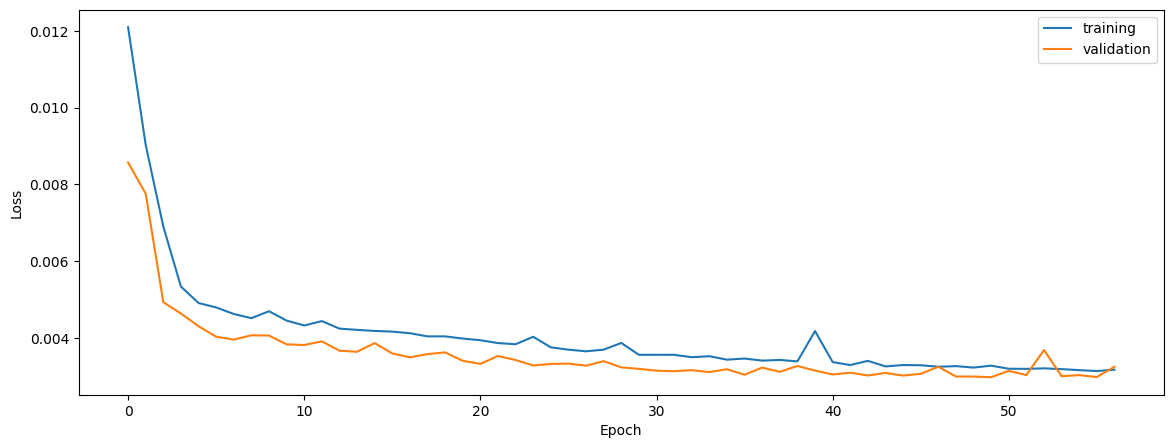

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8104893057120983
0.81250038900087
0.7933930402590313


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.8104893057120983
0.81250038900087
0.7933930402590313


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.8092942325800353
0.8125768566502334
0.7898268269028937


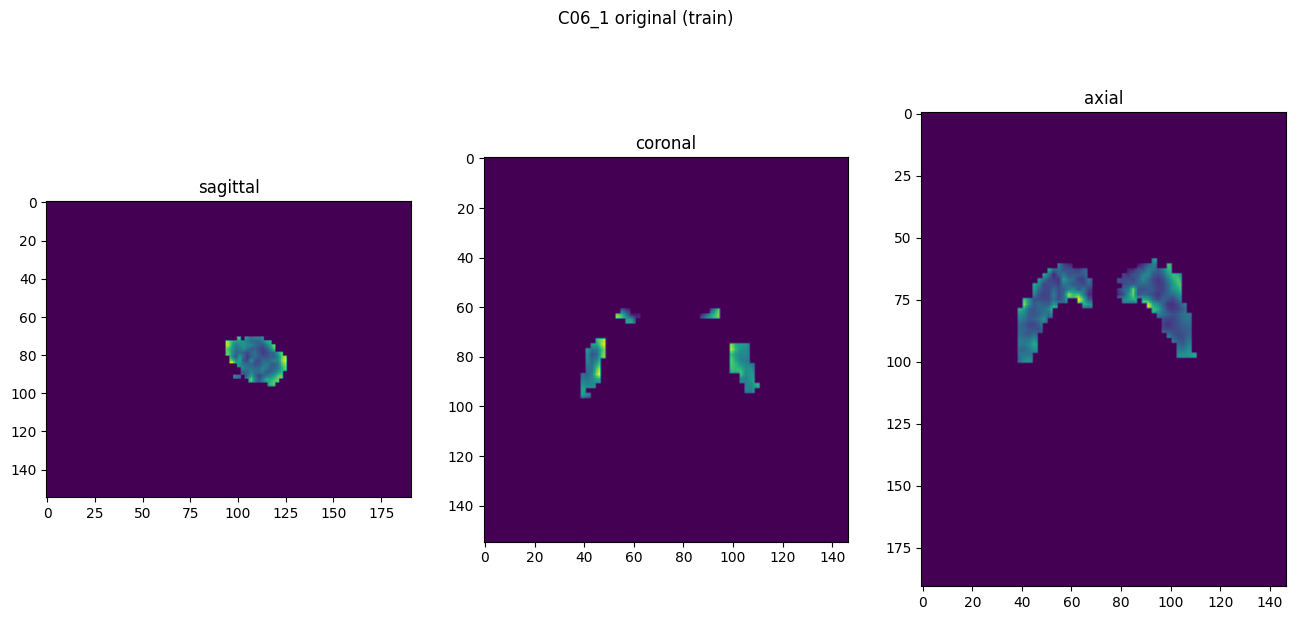

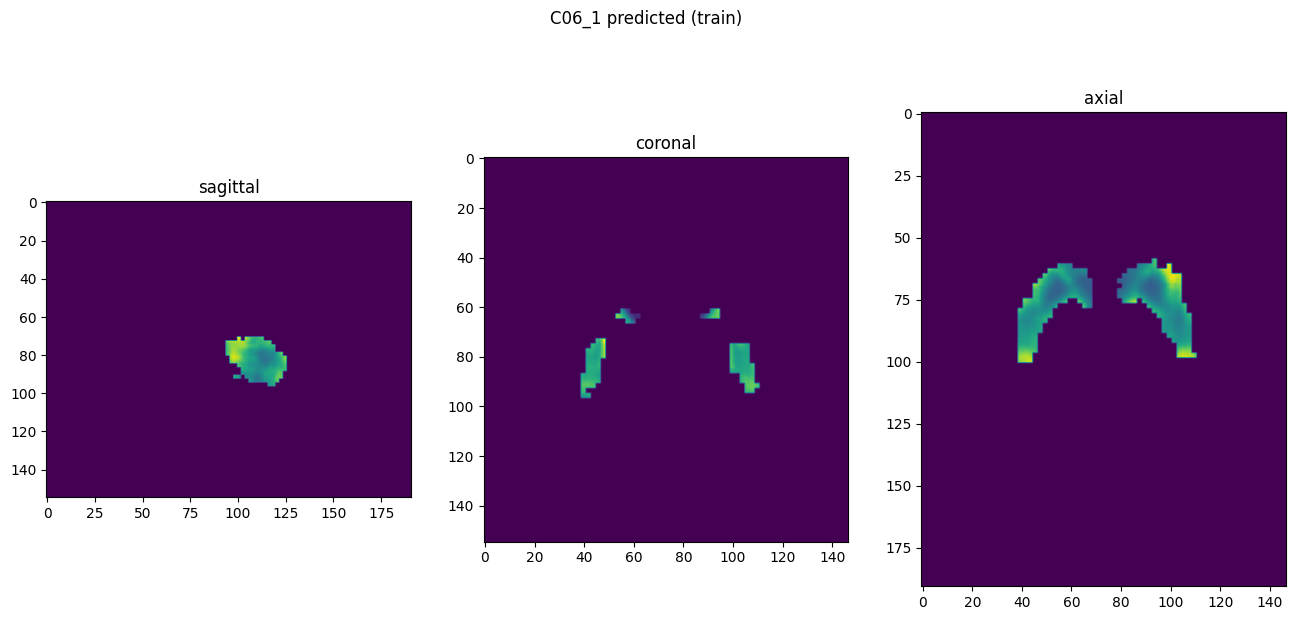

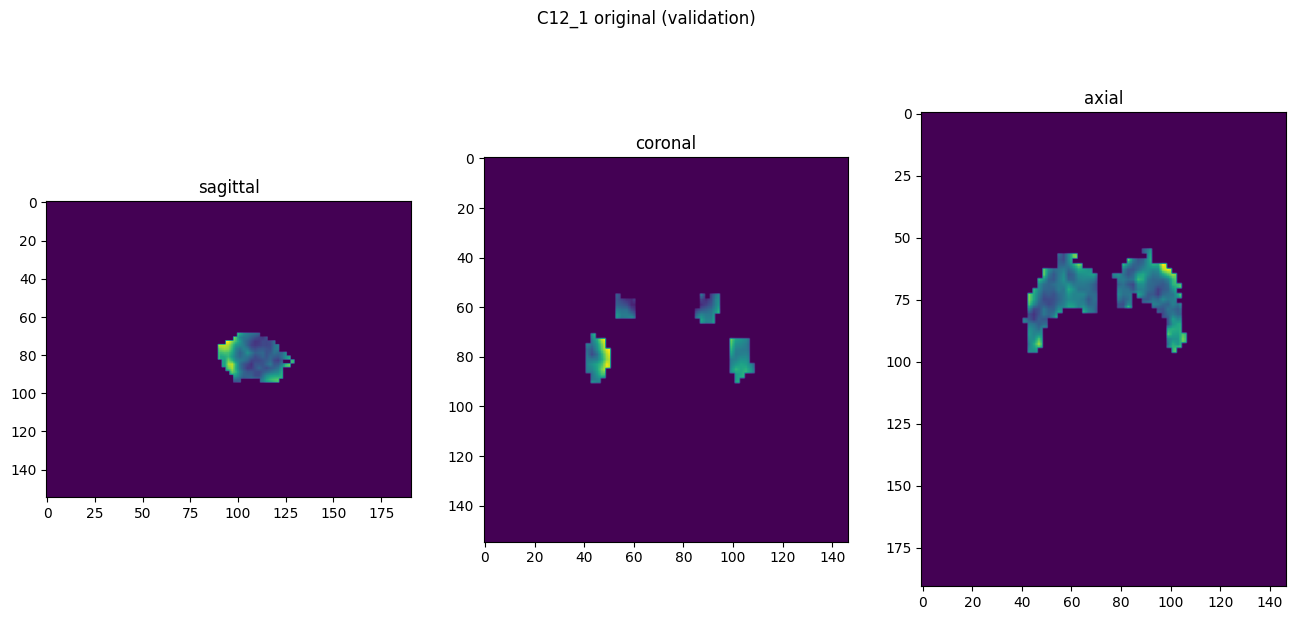

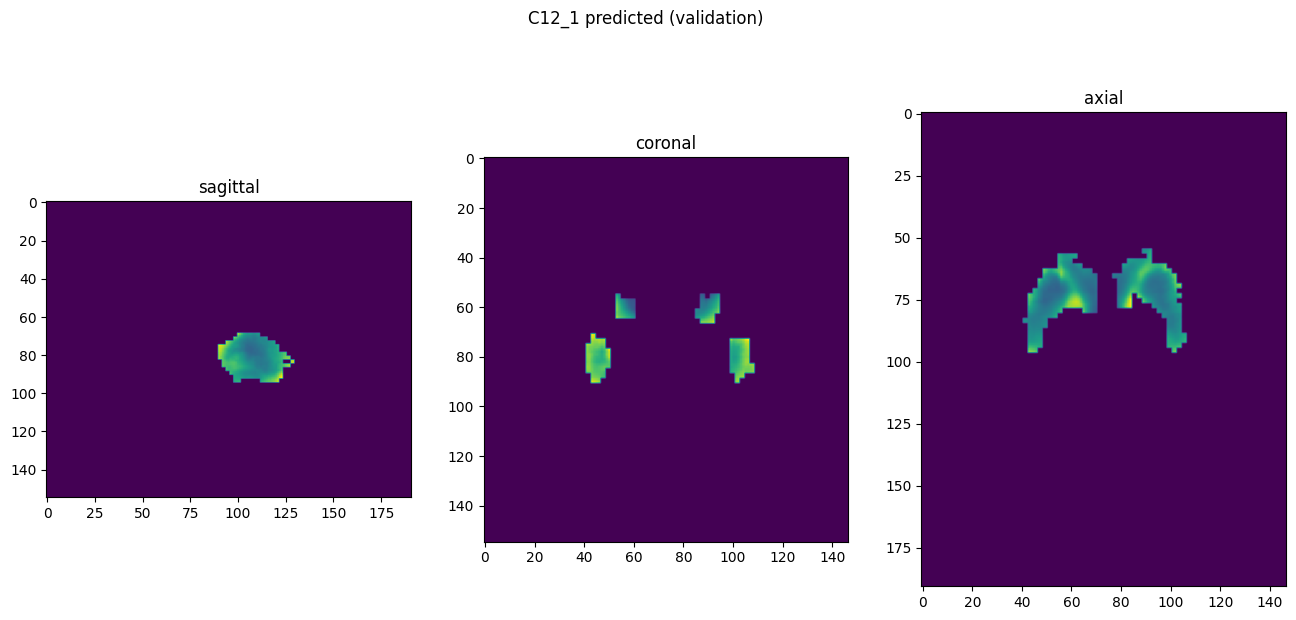

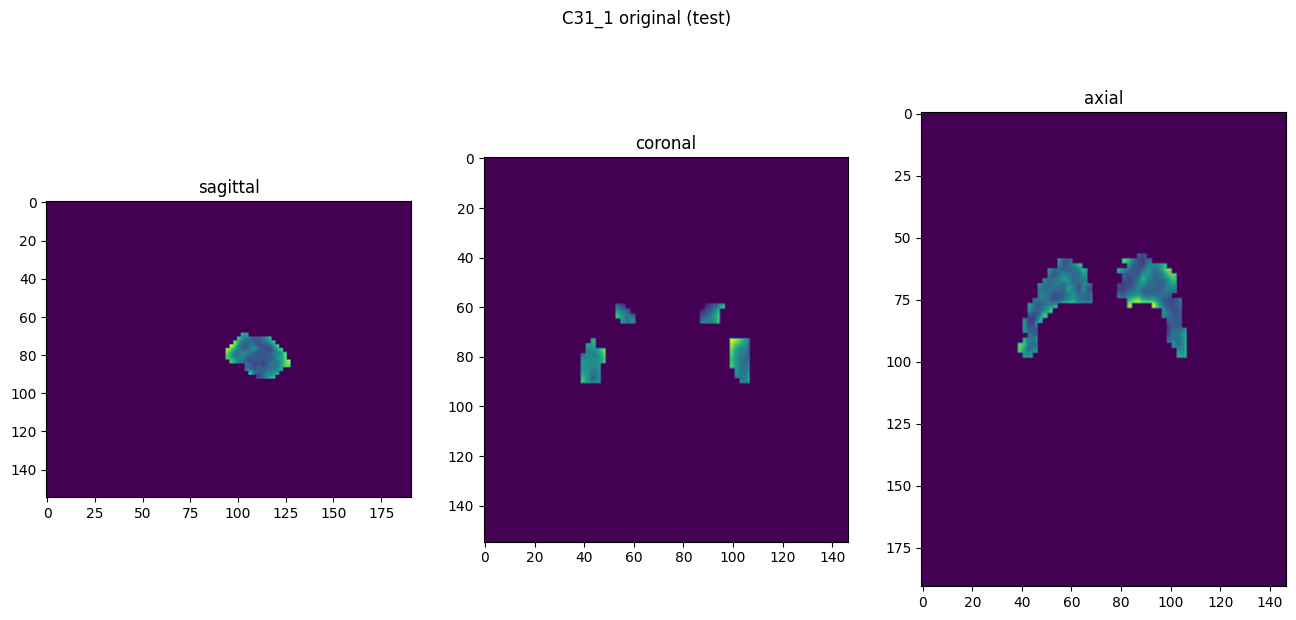

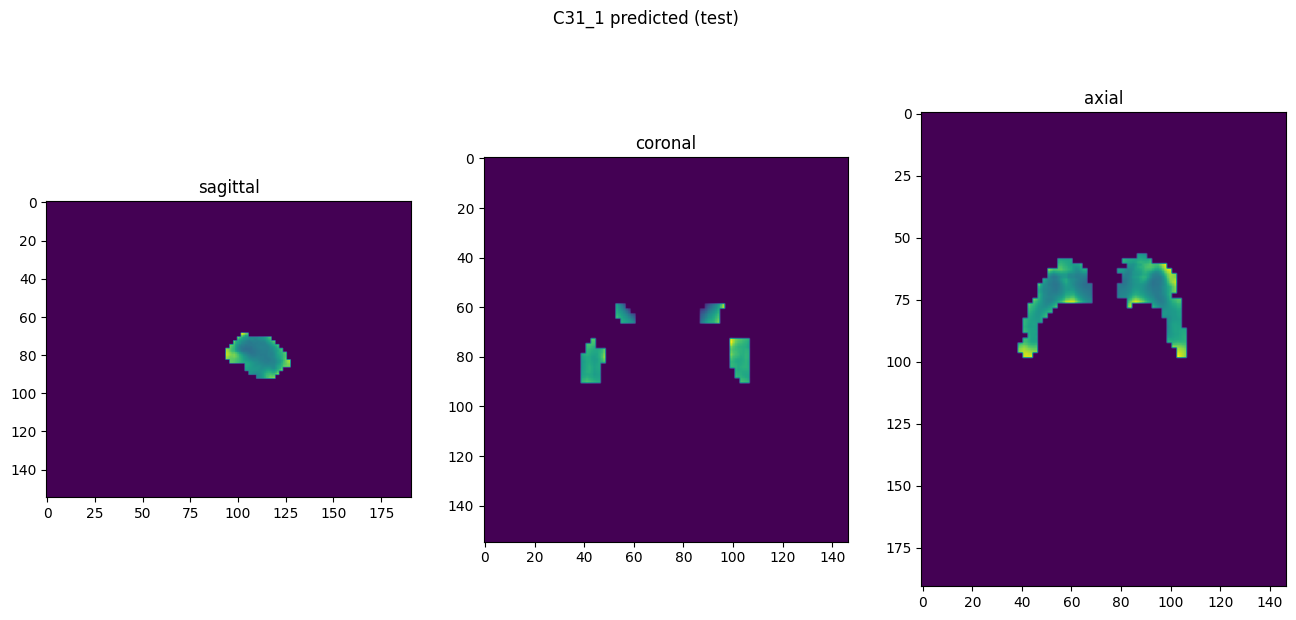

In [10]:
showResults(model, gen, threshold=None, background=False)